This cell is used only if the included functions are changed while running the jupyter code

In [1]:
%load_ext autoreload
%autoreload 2

## Include libraries

In [1]:
# Python 3.11.0
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Enable interactive plots in Jupyter Notebook (requires the ipympl package)
%matplotlib widget

# Import essential libraries for data manipulation, visualization, and computation
import matplotlib.pyplot as plt  # For plotting
import os  # For directory and file management
import pandas as pd  # For handling dataframes and CSV files
import numpy as np  # For numerical computations
import random  # For generating random numbers
import imageio  # For creating GIFs
from PIL import Image  # For image processing
from IPython.display import clear_output  # For clearing cell outputs
from tqdm import tqdm  # For displaying progress bars

# Import libraries for machine learning and neural networks
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.preprocessing import OneHotEncoder  # For one-hot encoding
from keras.models import Sequential  # For building neural network models
from keras.layers import Dense  # For defining layers in the neural network
from sklearn.metrics import confusion_matrix  # For evaluating model performance
from sklearn.manifold import TSNE  # For dimensionality reduction (t-SNE)

# Import the MNIST dataset from TensorFlow (only if you're online or the file has been already imported before)
from tensorflow.keras.datasets import mnist

# Import custom utility functions from the general functions module
from functions_general import *

In [2]:
plt.close('all')

## Dataset Parameters

In [3]:
num_digits_train = 60000 # Number of images for training
num_digits_test = 10000 # Number of images for testing
start_train = 0 # Index of first image in training
start_test = 0 # Index of first image in testing

################## Put the number of bits here
num_bits = 4

digit_rows_no_chop = 28 
digit_cols_no_chop = 28

digit_cols = num_bits
digit_rows = digit_cols_no_chop//digit_cols*digit_rows_no_chop #196
print(f'Digit rows: {digit_rows}')

Digit rows: 196


## Dataset Load, binarization, chopping and merging

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # Load the MNIST data. For the first time, the data will be downloaded, if the file was already been downloaded, it will be stored at the cache folder

# Use the following command when you are offline and the mnist dataset hasn't been installed previously:
#(x_train, y_train), (x_test, y_test) = import_mnist_offline('.\MNIST_data\mnist.npz')

digit_train_no_binarized = [np.zeros(shape=(digit_rows_no_chop, digit_cols_no_chop)) for i in range(0, num_digits_train)]
digit_test_no_binarized = [np.zeros(shape=(digit_rows_no_chop, digit_cols_no_chop)) for i in range(0, num_digits_test)]

digit_train_no_chop = [np.zeros(shape=(digit_rows_no_chop, digit_cols_no_chop)) for i in range(0, num_digits_train)]
digit_test_no_chop = [np.zeros(shape=(digit_rows_no_chop, digit_cols_no_chop)) for i in range(0, num_digits_test)]

digit_train = [[np.zeros(shape=(digit_rows, digit_cols))] for i in range(0, num_digits_train)]
digit_test = [[np.zeros(shape=(digit_rows, digit_cols))] for i in range(0, num_digits_test)]


digit_train_class = y_train[0+start_train:num_digits_train+start_train]
for i in range(0, num_digits_train):
    digit_train_no_binarized[i] = x_train[i+start_train]
    digit_train_no_chop[i] = np.round(digit_train_no_binarized[i]/256)
    digit_train[i] = np.reshape(digit_train[i], (digit_rows,digit_cols))
    for j in range(digit_cols_no_chop//digit_cols):
        digit_train[i][digit_rows_no_chop*j:digit_rows_no_chop*(j+1), :] = digit_train_no_chop[i][:, digit_cols*j:digit_cols*(j+1)]
    
digit_test_class = y_test[0+start_test:num_digits_test+start_test]
for i in range(0, num_digits_test):
    digit_test_no_binarized[i] = x_test[i+start_test]
    digit_test_no_chop[i] = np.round(digit_test_no_binarized[i]/256)
    digit_test[i] = np.reshape(digit_test[i], (digit_rows,digit_cols))
    for j in range(digit_cols_no_chop//digit_cols):
        digit_test[i][digit_rows_no_chop*j:digit_rows_no_chop*(j+1), :] = digit_test_no_chop[i][:, digit_cols*j:digit_cols*(j+1)]
    

## Digit display: 8 bit, binarized, chopped and merged

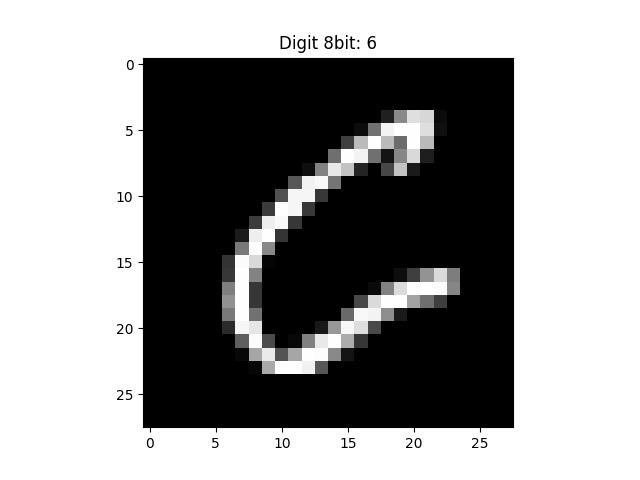

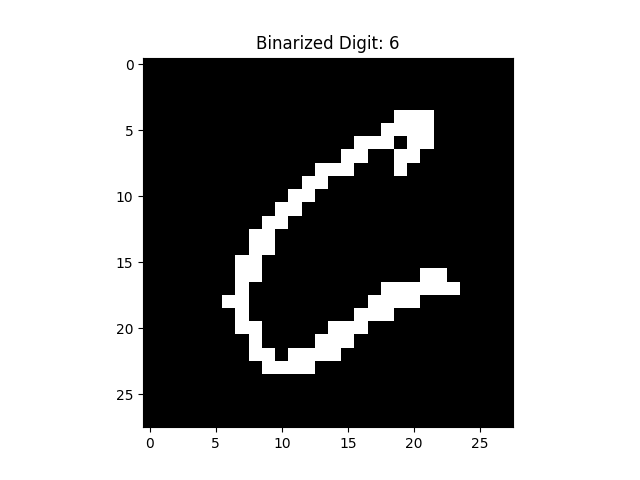

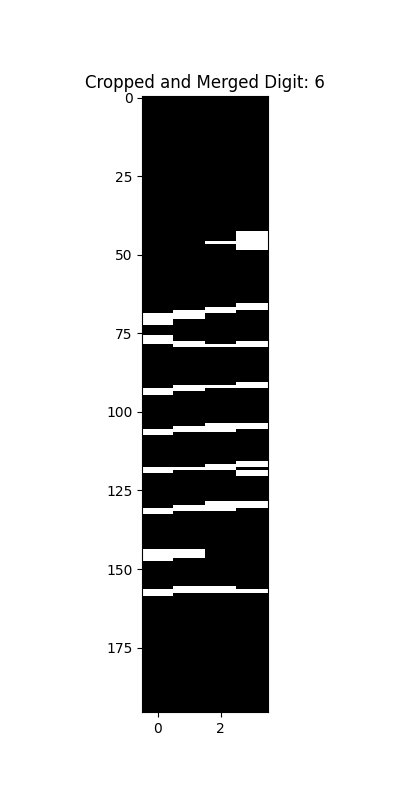

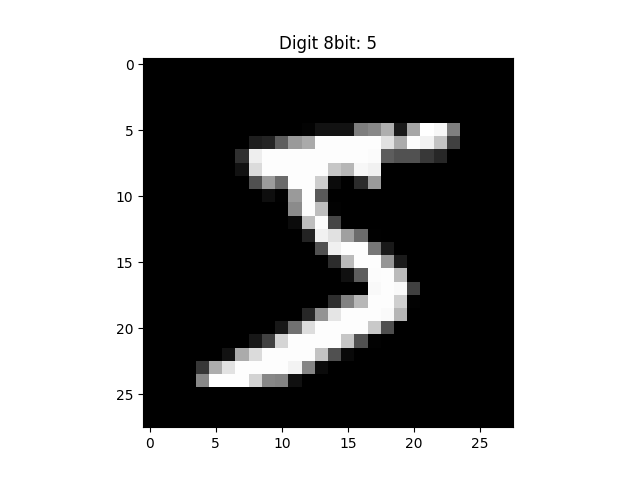

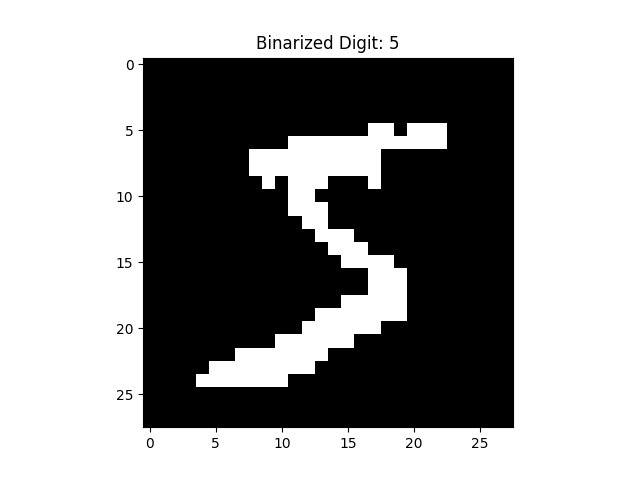

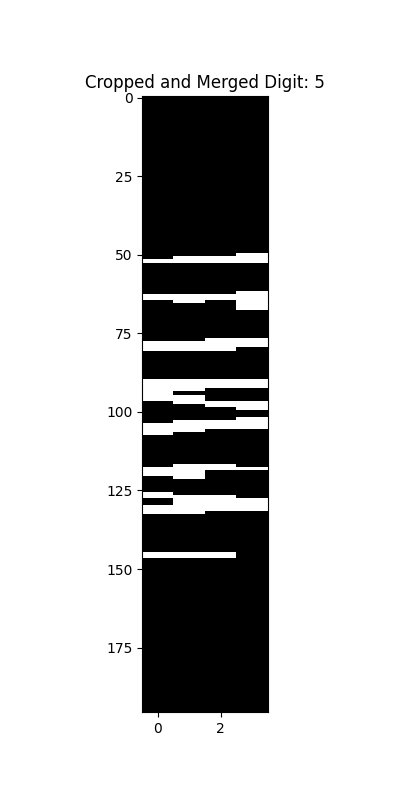

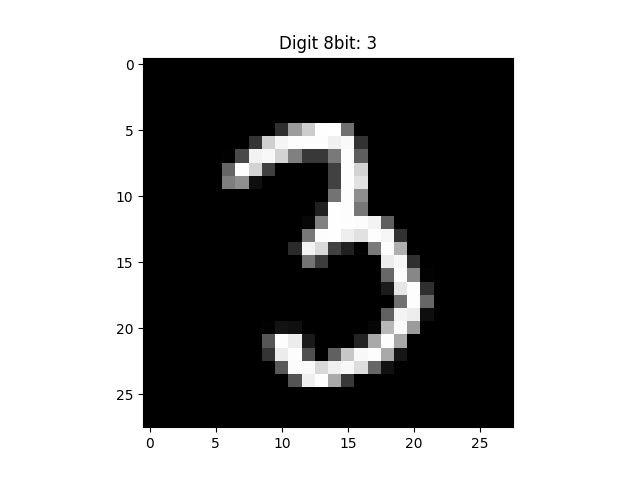

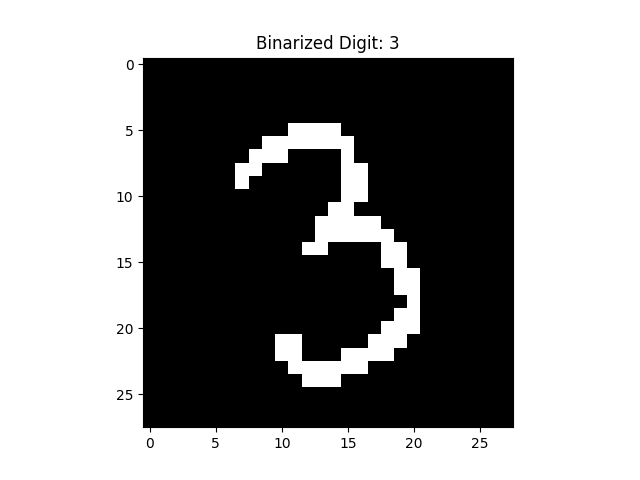

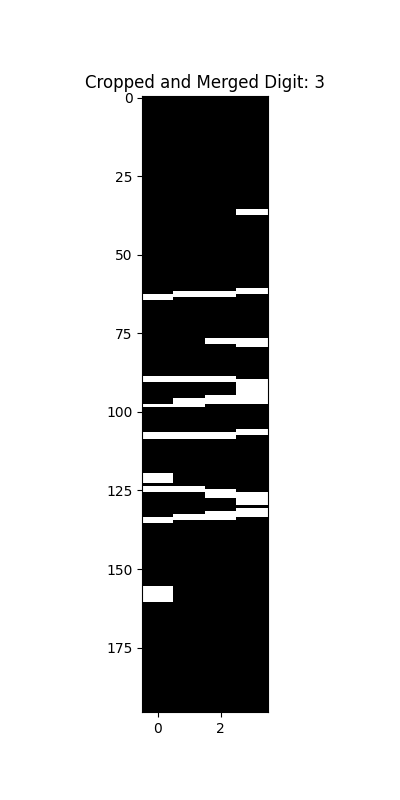

In [5]:
out_dir_digit_figs = './out_data/Figs_digits/'
if not os.path.exists(out_dir_digit_figs):
  os.makedirs(out_dir_digit_figs)

def plot_and_save_digit(digit_data, digit_class, idx, title_prefix, filename_prefix):
  if title_prefix == 'Cropped and Merged Digit':
    plt.figure(figsize=(4, 8))
    plt.imshow(digit_data, aspect=0.1, cmap='gray')
  else:
    plt.figure()
    plt.imshow(digit_data, cmap='gray')
  plt.title(f'{title_prefix}: {digit_class}')
  plt.savefig(out_dir_digit_figs + f'{filename_prefix}_{digit_class}_idx_{idx}.png')
  np.savetxt(out_dir_digit_figs + f'{filename_prefix}_{digit_class}_idx_{idx}.txt', digit_data)

indices_to_plot = [24934, 0, 30000]

for idx_to_plot in indices_to_plot:
  plot_and_save_digit(digit_train_no_binarized[idx_to_plot], digit_train_class[idx_to_plot], idx_to_plot, 'Digit 8bit', 'digit_8bit')
  plot_and_save_digit(digit_train_no_chop[idx_to_plot], digit_train_class[idx_to_plot], idx_to_plot, 'Binarized Digit', 'binarized_digit')
  plot_and_save_digit(digit_train[idx_to_plot], digit_train_class[idx_to_plot], idx_to_plot, 'Cropped and Merged Digit', 'cropped_and_merged_digit')


## Many digits plot

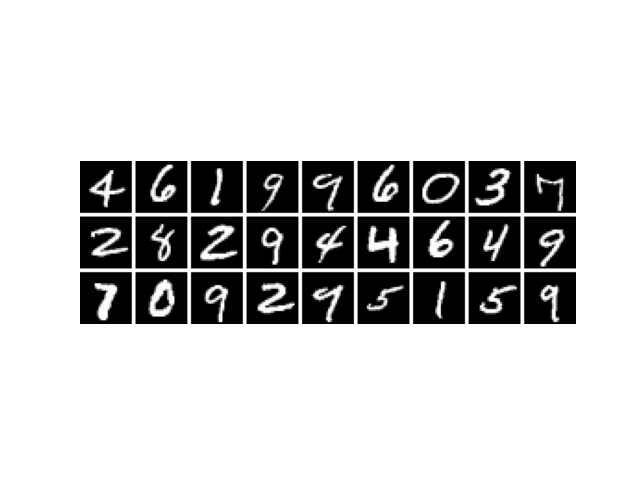

In [6]:
nx_images = 9
ny_images = 3
total_images = nx_images * ny_images
idx_first_image = 150
images_vector = [digit_train_no_binarized[idx_it] for idx_it in range(idx_first_image, idx_first_image+total_images)]

# Define the size of the separation space (in pixels)
separation = 2

# Create a grid of 9x3 images with separation spaces
grid_width = nx_images * 28 + (nx_images-1) * separation
grid_height = ny_images * 28 + (ny_images-1) * separation
grid = 255*np.ones((grid_height, grid_width))  # Initialize with ones for white background

for i in range(ny_images):
    for j in range(nx_images):
        start_row = i * (28 + separation)
        start_col = j * (28 + separation)
        grid[start_row:start_row + 28, start_col:start_col + 28] = images_vector[i * nx_images + j]

# Display the grid of images
plt.figure()
plt.imshow(grid, cmap='gray')
plt.axis('off')  # Hide the axes

plt.show()

# Save the grid of images:
grid_image = Image.fromarray((grid).astype(np.uint8)) # Save the image as a BMP file 
grid_image.save(out_dir_digit_figs + 'digits_grid_image.bmp')


## Open files for experimental data of bit impulses

In [7]:
dataset = '12122024_20-14-55'

relative_path = f'Data to process/{num_bits} bits/{dataset}/'
folders = os.listdir(relative_path)

parameters_data = pd.read_csv(f'{relative_path}/Parameters.txt', sep='\t', header=0)
start_waiting_time = parameters_data['Time before sequence E6 (ms)'].to_numpy()
T_on = parameters_data['T_on E6 (ms)'].to_numpy()
T_off = parameters_data['T_off E6 (ms)'].to_numpy()

all_data = []
for folder in folders:
    single_folder_path = f'{relative_path}{folder}'
    if os.path.isdir(single_folder_path):
        files_in_folder = os.listdir(single_folder_path)
        set_data = {}
        for single_file_name in files_in_folder:
            single_data = np.loadtxt(
                f'{single_folder_path}/{single_file_name}',
                  delimiter='\t')
            single_data_dict = {}
            single_data_dict['time'] = single_data[:, 1]
            single_data_dict['intensity'] = single_data[:, 2]
            set_data[single_file_name.replace('.txt', '')] = single_data_dict
        all_data.append(set_data)

## Plot the experimental data and select the data at 100ms after the last bit

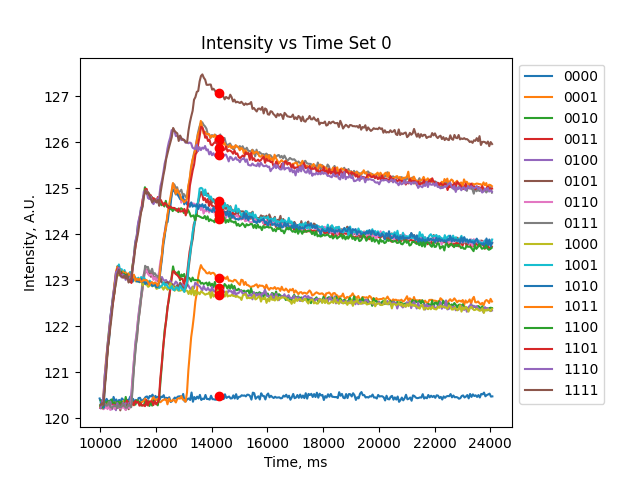

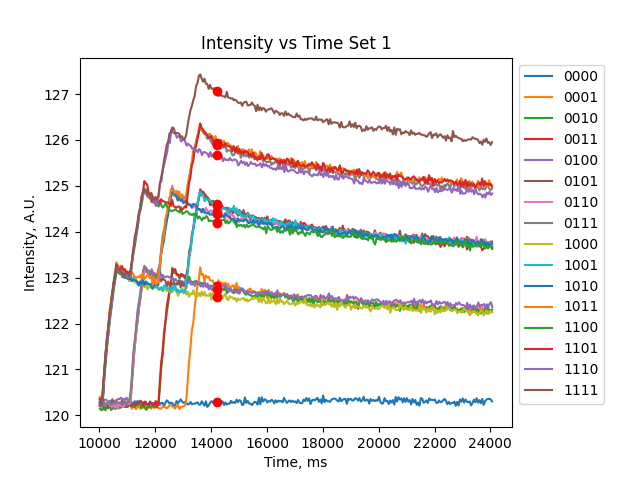

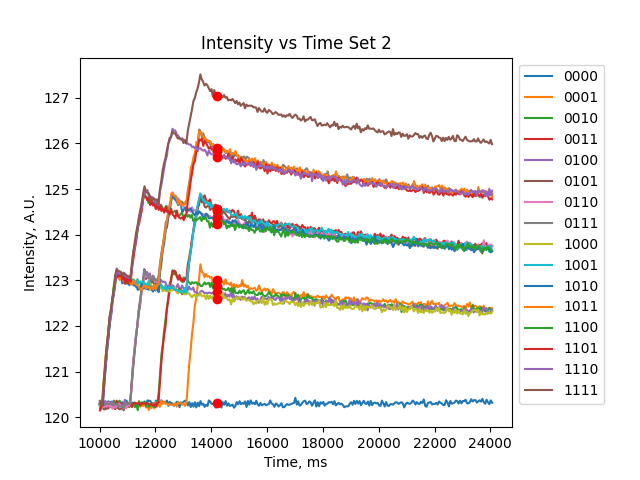

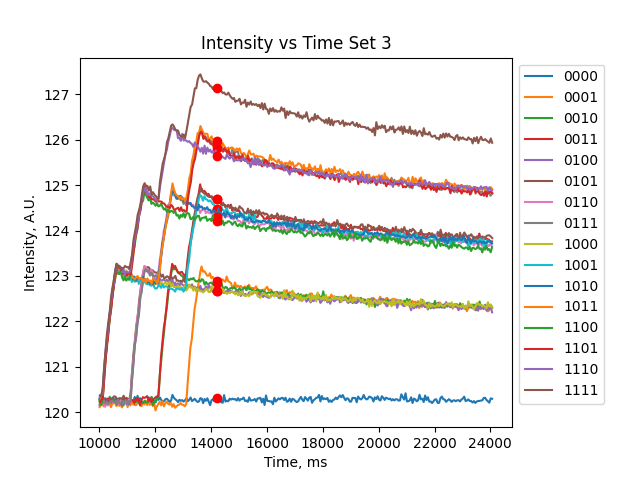

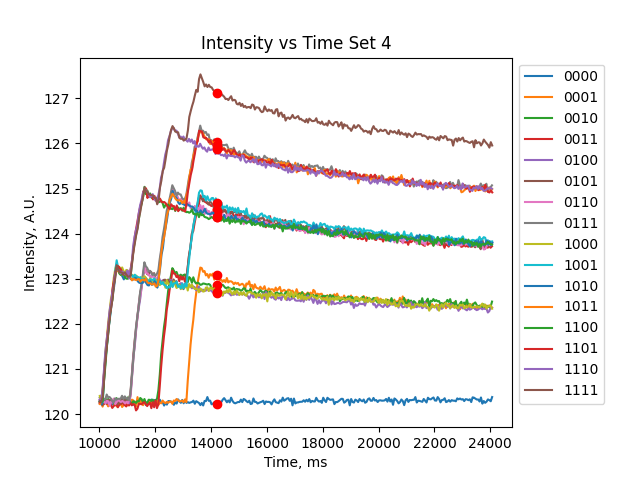

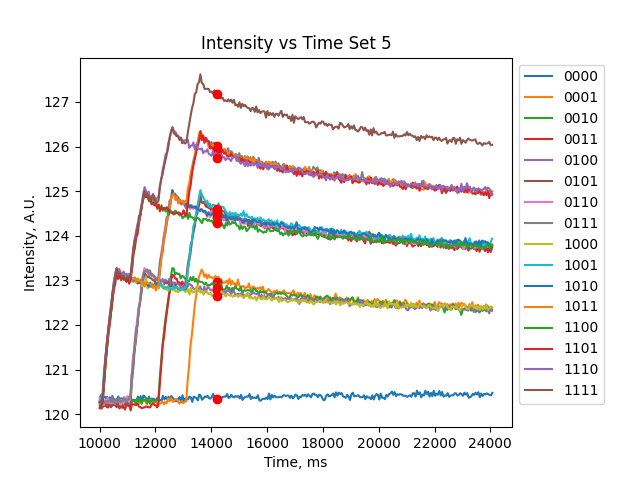

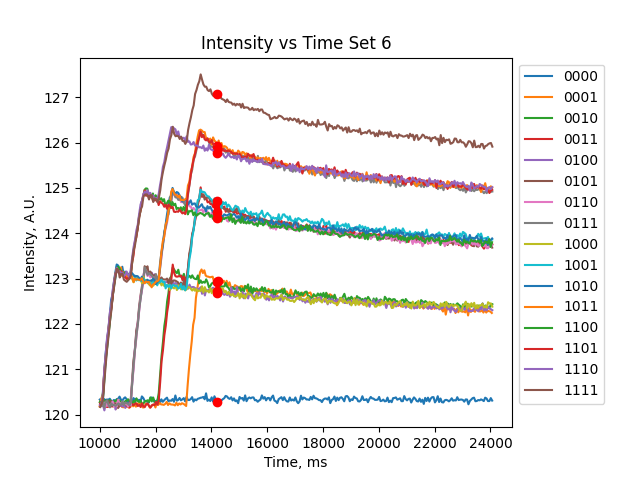

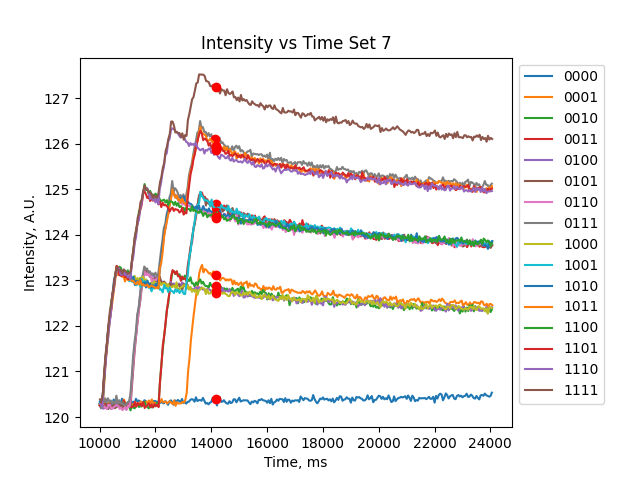

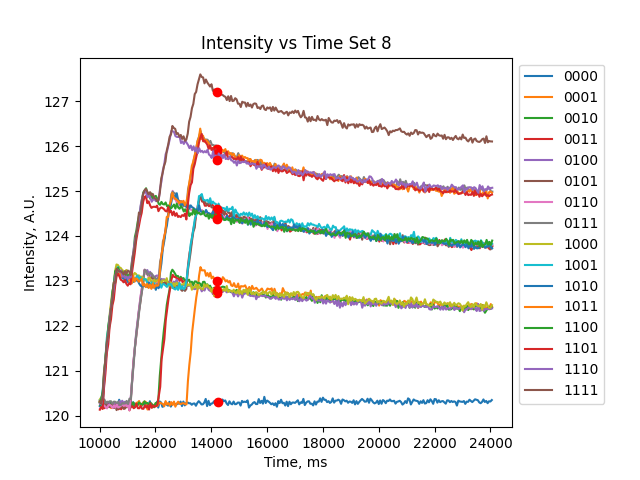

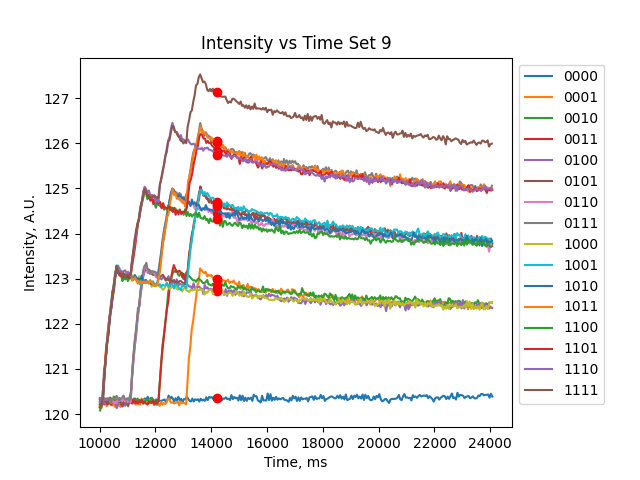

In [8]:
out_dir_plot_figures = './out_data/Single_data_plots/'
if not os.path.exists(out_dir_plot_figures):
    os.makedirs(out_dir_plot_figures)
plt.close('all')
time_offset = 100
data_at_specific_time = {}
for key in all_data[0].keys():
    data_at_specific_time[key] = []
for set_idx, single_set in enumerate(all_data):
    plt.figure()
    idx_max = np.argmax(single_set['1'*num_bits]['intensity'])
    for bin_number, single_data in single_set.items():
        time_v = single_data['time']
        intensity_v = single_data['intensity']
        idx_beggining = find_nearest_value_index(time_v, start_waiting_time)
        idx_at_specific_time = find_nearest_value_index(time_v, time_v[idx_max] + T_off + time_offset)
        data_at_specific_time[bin_number].append(intensity_v[idx_at_specific_time].item())
        plt.plot(time_v[idx_beggining:], intensity_v[idx_beggining:], label=bin_number)
        plt.plot(time_v[idx_at_specific_time], intensity_v[idx_at_specific_time], 'ro')
    plt.xlabel('Time, ms')
    plt.ylabel('Intensity, A.U.')
    plt.title(f'Intensity vs Time Set {set_idx}')
    plt.subplots_adjust(right=0.8)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    plt.savefig(out_dir_plot_figures+f'Set_{set_idx}_dataset_{dataset}_plot.png', format="png", dpi=1200)


## Plot the Boxplot

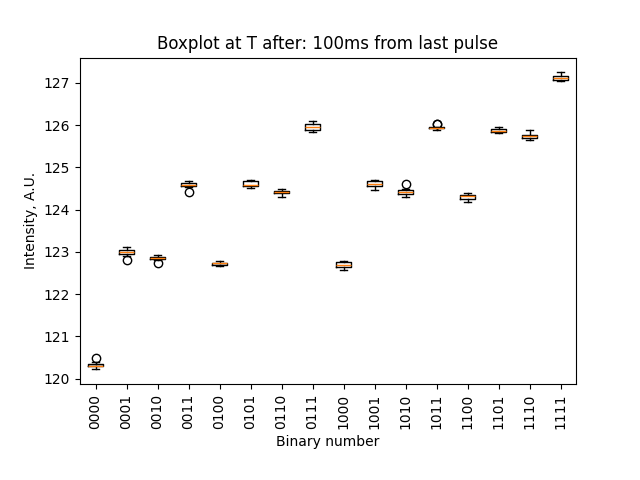

In [9]:
out_dir_boxplot = './out_data/Boxplot/'
if not os.path.exists(out_dir_boxplot):
    os.makedirs(out_dir_boxplot)
df_PAZO = pd.DataFrame(data_at_specific_time)
df_PAZO.to_csv(out_dir_boxplot+f'Dataframe_for_boxplot_{dataset}.csv')

# Box plot:
binary_numbers = df_PAZO.columns.values.tolist()
x_vector = [*range(1, len(binary_numbers)+1)]
plt.figure()
plt.subplots_adjust(bottom=0.2)
plt.boxplot(df_PAZO)
plt.xticks(x_vector, binary_numbers, rotation='vertical')
plt.title(f'Boxplot at T after: {time_offset}ms from last pulse')
plt.xlabel("Binary number")
plt.ylabel("Intensity, A.U.")
plt.show()
plt.savefig(out_dir_boxplot+f'Boxplot_{dataset}.png', format="png", dpi=1200)

## TSNE 2D calculation

Testing set: 100%|██████████| 10000/10000 [00:03<00:00, 3298.10it/s]


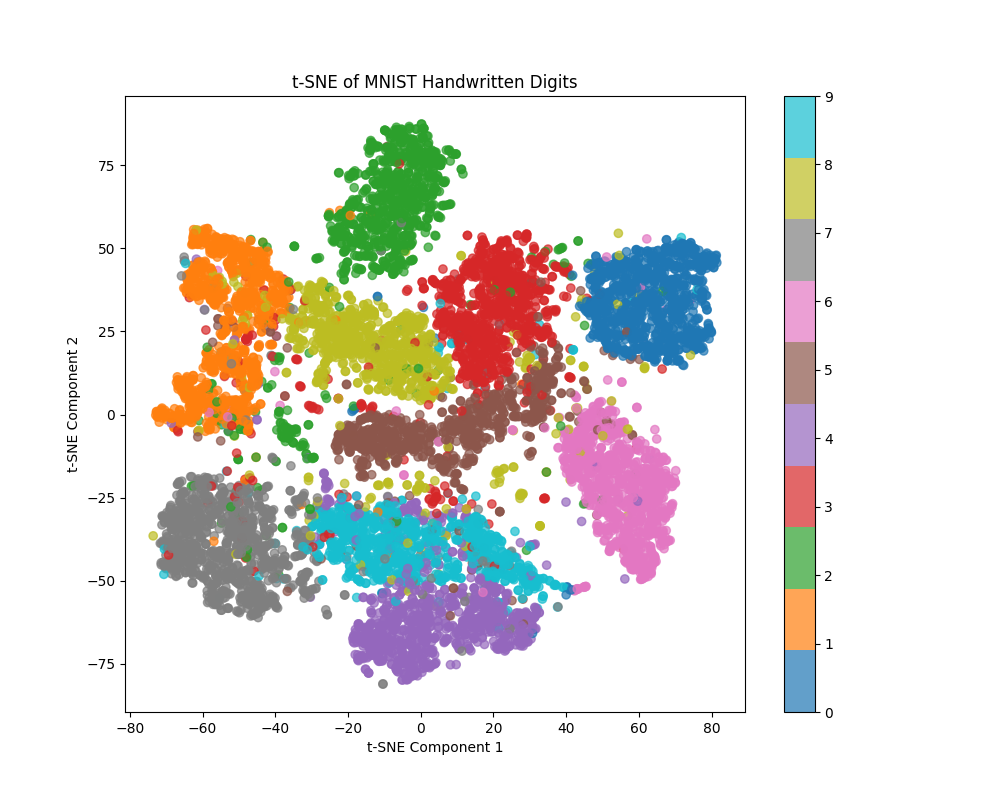

In [10]:
out_dir_TSNE = './out_data/TNSE/'
if not os.path.exists(out_dir_TSNE):
    os.makedirs(out_dir_TSNE)
selector_reservoir = 0
n_tsne = 10000
random.seed(5)
(digit_train_reduced_np, digit_test_reduced_np) = assign_experimental_data_with_digit(data_at_specific_time, digit_rows, num_digits_train, num_digits_test, digit_train, digit_test, selector_reservoir)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(digit_train_reduced_np[:n_tsne,:])
plt.figure(figsize=(10, 8)) 
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=digit_train_class[:n_tsne].astype(int), cmap='tab10', alpha=0.7) 
plt.colorbar(scatter, ticks=range(10)) 
plt.title('t-SNE of MNIST Handwritten Digits') 
plt.xlabel('t-SNE Component 1') 
plt.ylabel('t-SNE Component 2') 
plt.show()
plt.savefig(out_dir_TSNE+f'TSNE_2D_n_{n_tsne}.png', format="png", dpi=1200)

matrix_tnse = np.vstack((X_tsne[:, 0], X_tsne[:, 1], digit_train_class[:n_tsne]))
np.savetxt(out_dir_TSNE+'matrix_tnse_2D.txt', matrix_tnse.T)

## TSNE 3D calculation

Testing set: 100%|██████████| 10000/10000 [00:02<00:00, 3802.45it/s]


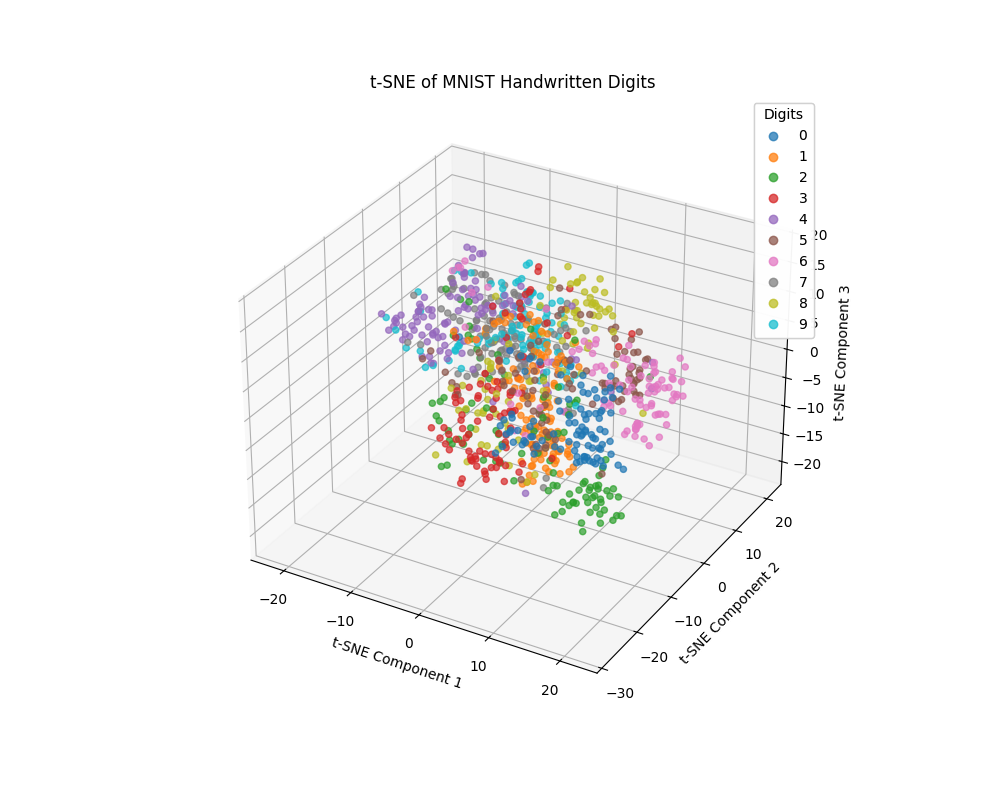

In [11]:
out_dir_TSNE = './out_data/TNSE/'
if not os.path.exists(out_dir_TSNE):
    os.makedirs(out_dir_TSNE)
selector_reservoir = 1 #Instead of PAZO information, the vector is filled with the last bit of the image
n_tsne = 1000
random.seed(5)
(digit_train_reduced_np, digit_test_reduced_np) = assign_experimental_data_with_digit(data_at_specific_time, digit_rows, num_digits_train, num_digits_test, digit_train, digit_test, selector_reservoir)

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(digit_train_reduced_np[:n_tsne,:])
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=digit_train_class[:n_tsne].astype(int), cmap='tab10', alpha=0.7) 
legend = ax.legend(*scatter.legend_elements(), title="Digits")
ax.add_artist(legend)
ax.set_title('t-SNE of MNIST Handwritten Digits') 
ax.set_xlabel('t-SNE Component 1') 
ax.set_ylabel('t-SNE Component 2') 
ax.set_zlabel('t-SNE Component 3') 
plt.show()
plt.savefig(out_dir_TSNE+f'TSNE_3D_n_{n_tsne}.png', format="png", dpi=1200)

matrix_tnse = np.vstack((X_tsne[:, 0], X_tsne[:, 1], digit_train_class[:n_tsne]))
np.savetxt(out_dir_TSNE+'matrix_tnse_3D.txt', matrix_tnse.T)

## Export TSNE 3D gif

C:\Users\a.angelini\AppData\Local\Temp\ipykernel_17452\973737168.py:16: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


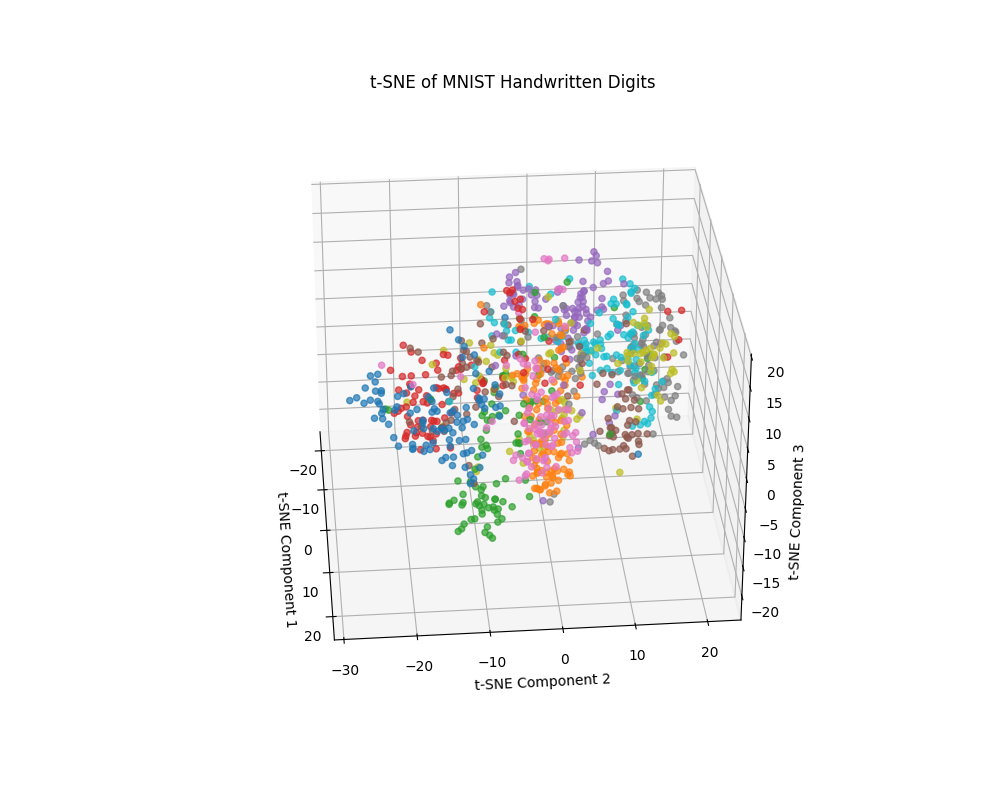

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
def update_plot(angle):
    ax.clear()
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=digit_train_class[:n_tsne].astype(int), cmap='tab10', alpha=0.7) 
    ax.set_title('t-SNE of MNIST Handwritten Digits') 
    ax.set_xlabel('t-SNE Component 1') 
    ax.set_ylabel('t-SNE Component 2') 
    ax.set_zlabel('t-SNE Component 3')
    ax.view_init(30, angle)
    return fig
frames = []
for angle in range(0, 360, 5):
    update_plot(angle)
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1]+(3,))
    frames.append(image)
imageio.mimsave(out_dir_TSNE+'tsne_animation_3d.gif', frames, fps=10)

## Loop to evaluate the accuracy in n repetitions:

Doing calculations for repetition 0
Assigning experimental data with digits


Testing set: 100%|██████████| 10000/10000 [00:03<00:00, 3190.39it/s]


Performing training
Epoch 1/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1519 - loss: 2.6961 
Epoch 2/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5554 - loss: 1.4228
Epoch 3/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7212 - loss: 0.9498
Epoch 4/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7955 - loss: 0.7284
Epoch 5/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8254 - loss: 0.6305
Epoch 6/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8455 - loss: 0.5609
Epoch 7/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8582 - loss: 0.5171
Epoch 8/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8656 - loss: 0.4832
Epoch 9/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.4627
Epoch 10/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8767 - loss: 0.4362
Epoch 11/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8786 - loss: 0.4239
Epoch 12/800
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s

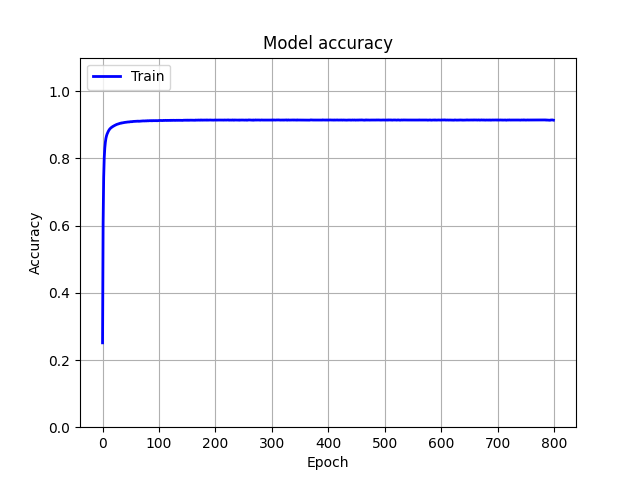

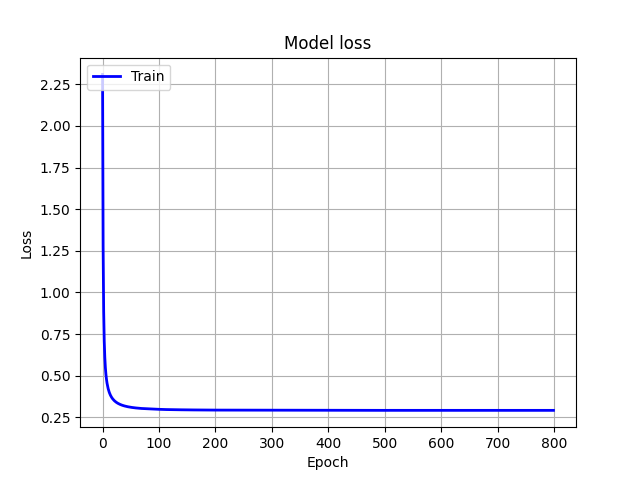

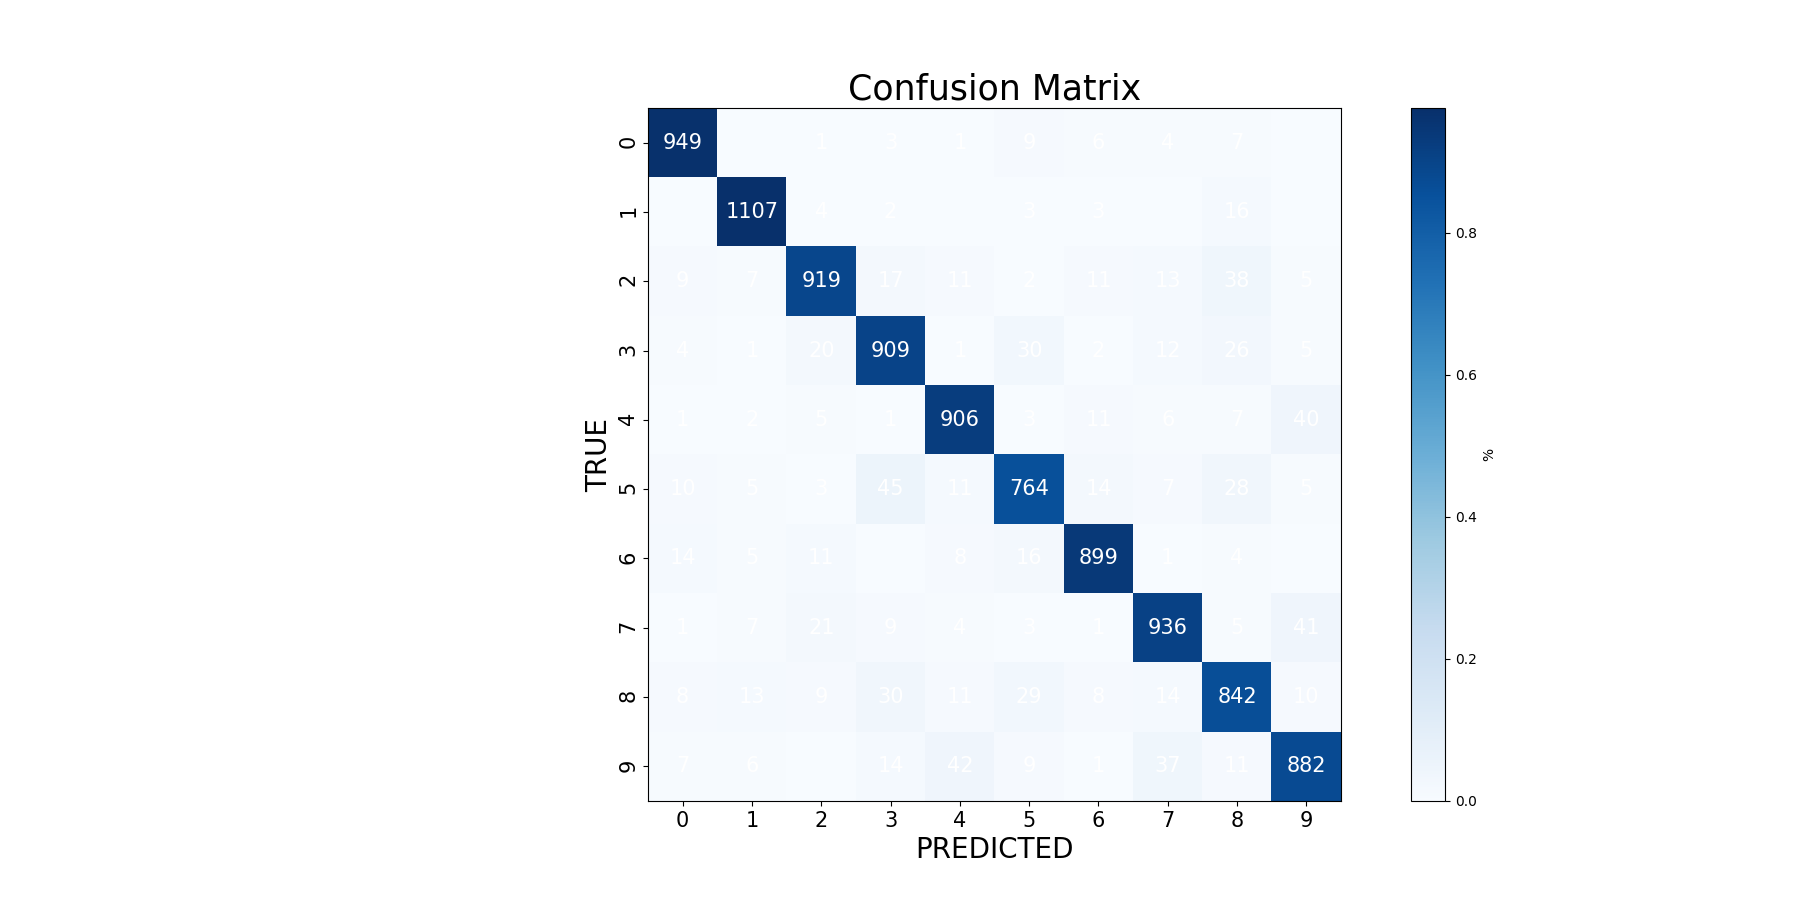

Test accuracy: 0.9113


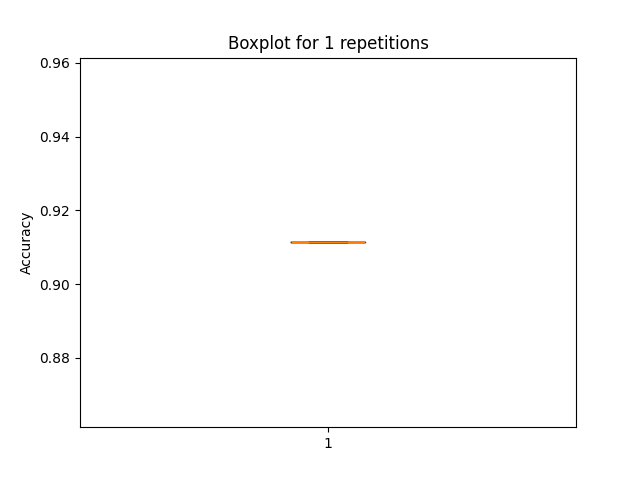

In [13]:
out_dir_training_outputs = './out_data/Training_outputs/'
if not os.path.exists(out_dir_training_outputs):
    os.makedirs(out_dir_training_outputs)
plot_data = 1
save_data = 1
verbose_training = 1
clear_output_in_iteration = 0
save_first_digit = 1 # Save information about the first digit
data_first_digit_train_v = []
data_first_digit_test_v = []

selector_reservoir = 0

epochs = 800
batch_size = 1500

n_repetitions = 1
accuracy_v = [] # Accuracy vector to store the values of accuracy for the different repetitions
random.seed(5)
for repetition in range(n_repetitions):
    print(f'Doing calculations for repetition {repetition}')
    ##################################################
    # Convert PAZO data into the MNIST data:
    print('Assigning experimental data with digits')
    (digit_train_reduced_np, digit_test_reduced_np) = assign_experimental_data_with_digit(data_at_specific_time, digit_rows, num_digits_train, num_digits_test, digit_train, digit_test, selector_reservoir)
    data_first_digit_train_v.append(digit_train_reduced_np[0][:])
    data_first_digit_test_v.append(digit_test_reduced_np[0][:])
        
    ##################################################
    # Perform the training
    print('Performing training')
    (history, conf_matrix, conf_matrix_norm, test_accuracy, y_pred_class, test_out) = perform_training(start_train, start_test, num_digits_train, num_digits_test, digit_train_class, digit_test_class, epochs, batch_size, digit_train_reduced_np, digit_test_reduced_np, verbose_training)
    
    if plot_data == 1:
        plot_training_data(out_dir_training_outputs, history, conf_matrix, conf_matrix_norm, repetition)
    
    np.savetxt(out_dir_training_outputs+f'conf_matrix_ep{epochs}'+'_batch'+str(batch_size)+'.txt', conf_matrix)
    np.savetxt(out_dir_training_outputs+'conf_matrix_norm_ep'+str(epochs)+'_batch'+str(batch_size)+'.txt', conf_matrix_norm)
    print(f'Test accuracy: {test_accuracy}')
    accuracy_v.append(test_accuracy)
    if clear_output_in_iteration == 1:
        plt.close('all')
        clear_output(wait=True)

# Box plot:
plt.figure()
plt.boxplot(accuracy_v)
plt.title(f'Boxplot for {n_repetitions} repetitions')
plt.ylabel("Accuracy")
plt.show()

out_dir_accuracy = f'./out_data/Accuracy/{num_bits} bits/{dataset}/'

if save_data == 1:
    if not os.path.exists(out_dir_accuracy):
        os.makedirs(out_dir_accuracy)
    np.savetxt(out_dir_accuracy + f'accuracy_vector_{n_repetitions}_repetitions_{dataset}.txt', accuracy_v)
    

if save_first_digit == 1:
    if not os.path.exists(out_dir_accuracy):
        os.makedirs(out_dir_accuracy)
    np.savetxt(out_dir_accuracy + f'first_digit_train_{dataset}.txt', np.array(data_first_digit_train_v).T)
    np.savetxt(out_dir_accuracy + f'first_digit_test_{dataset}.txt', np.array(data_first_digit_test_v).T)

# Save the confusion matrix data:
confusion_data_matrix = np.column_stack([test_out[:,0], y_pred_class])
df_confusion_data_matrix = pd.DataFrame(confusion_data_matrix, columns=['Test out', 'Predicted'])
df_confusion_data_matrix.to_csv(out_dir_accuracy+f'confusion_data_matrix_{dataset}.csv', index=False)

## Plot of a digit and its PSI

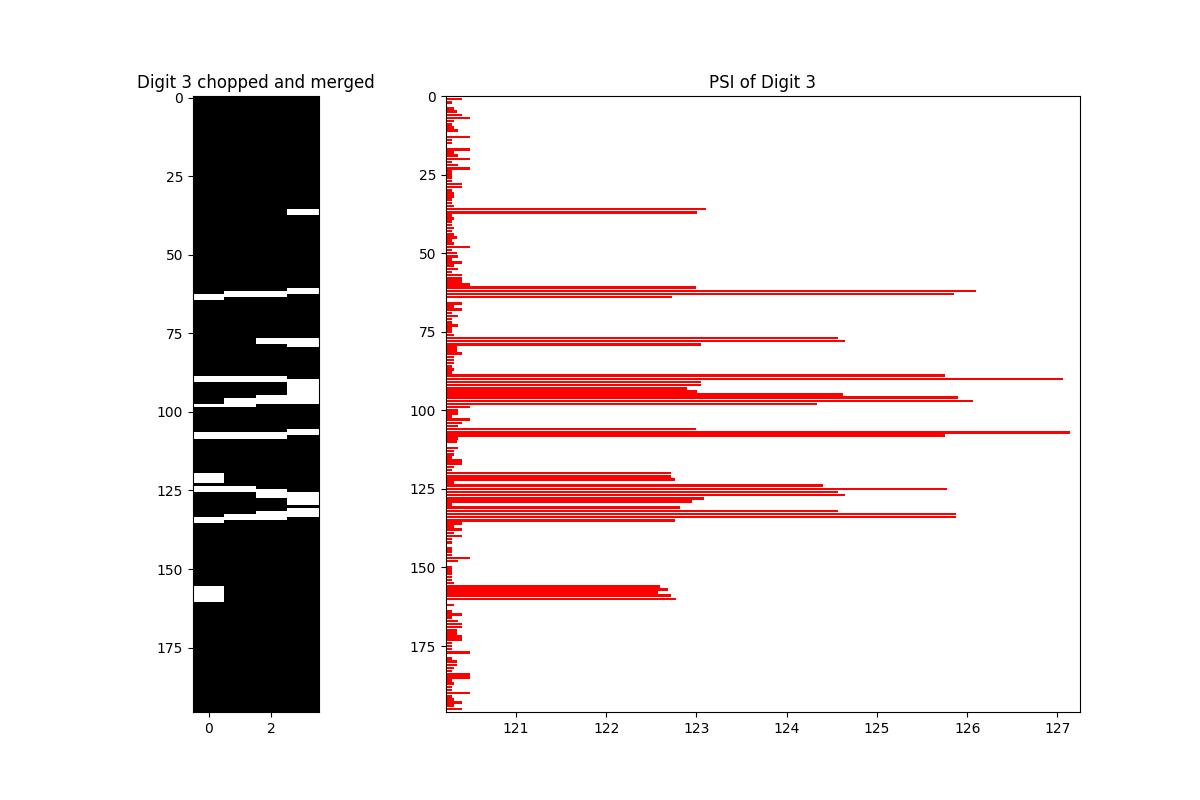

In [14]:
out_dir_histogram = './out_data/Figs_histogram/'
if not os.path.exists(out_dir_histogram):
    os.makedirs(out_dir_histogram)

idx_to_plot = 30000

fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, width_ratios=[1, 3], figsize=(12,8))
a0.imshow(digit_train[idx_to_plot], aspect= 0.1, cmap='gray')
a0.set_title(f'Digit {digit_train_class[idx_to_plot]} chopped and merged')
a1.barh(range(1,len(digit_train_reduced_np[idx_to_plot,1:])+1), digit_train_reduced_np[idx_to_plot,1:], color='red', alpha=1)
a1.set_xlim([np.min(digit_train_reduced_np[:,1:]), np.max(digit_train_reduced_np[:,1:])])
a1.set_ylim([0, 196])
a1.invert_yaxis()
a1.set_title(f'PSI of Digit {digit_train_class[idx_to_plot]}')
plt.show()
plt.savefig(out_dir_histogram+f'histogram_digit_{digit_train_class[idx_to_plot]}_idx_{idx_to_plot}.png', format="png", dpi=1200)

